In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from stdp_snn import Classifier
import time

In [2]:
NUM_INPUT_NEURONS = 4  # 4 признака в Iris dataset
NUM_HIDDEN_NEURONS = [10]
NUM_OUTPUT_NEURONS = 3  # 3 класса в Iris

In [3]:
# Загружаем датасет Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Масштабируем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделим данные на обучающую и тестовую выборки
X_train = np.concatenate((X[0:30], X[50:80], X[100:130]))
X_test = np.concatenate((X[30:50], X[80:100], X[130:150]))
y_train = np.concatenate((y[0:30], y[50:80], y[100:130]))
y_test = np.concatenate((y[30:50], y[80:100], y[130:150]))

In [4]:
classifier = Classifier("lif", "sstdp", NUM_INPUT_NEURONS, NUM_HIDDEN_NEURONS, NUM_OUTPUT_NEURONS)
classifier.reset_weights()

In [5]:
classifier.print_weights()

Output weights:
[0.95803898 0.05102734 0.12643785 0.60282005 0.93663111 0.63226782
 0.63454422 0.0778676  0.00576446 0.27146123]
[0.69006385 0.93917773 0.36119356 0.04259568 0.32607038 0.37951603
 0.7120372  0.40597805 0.52278826 0.69642064]
[0.59961591 0.58710599 0.55833829 0.3805705  0.35171918 0.48862179
 0.77272371 0.15398864 0.93535883 0.96145782]



Epoch: 0; Accuracy: 58.88888888888889

Epoch: 1; Accuracy: 60.0

Epoch: 2; Accuracy: 60.0

              Операций: 6223557; 
              Доля умножений: 0.3383916946530738; 
              Операций за проход: 5.910310541310541; 
              Доля спайковых операций: 0.21297150997150996


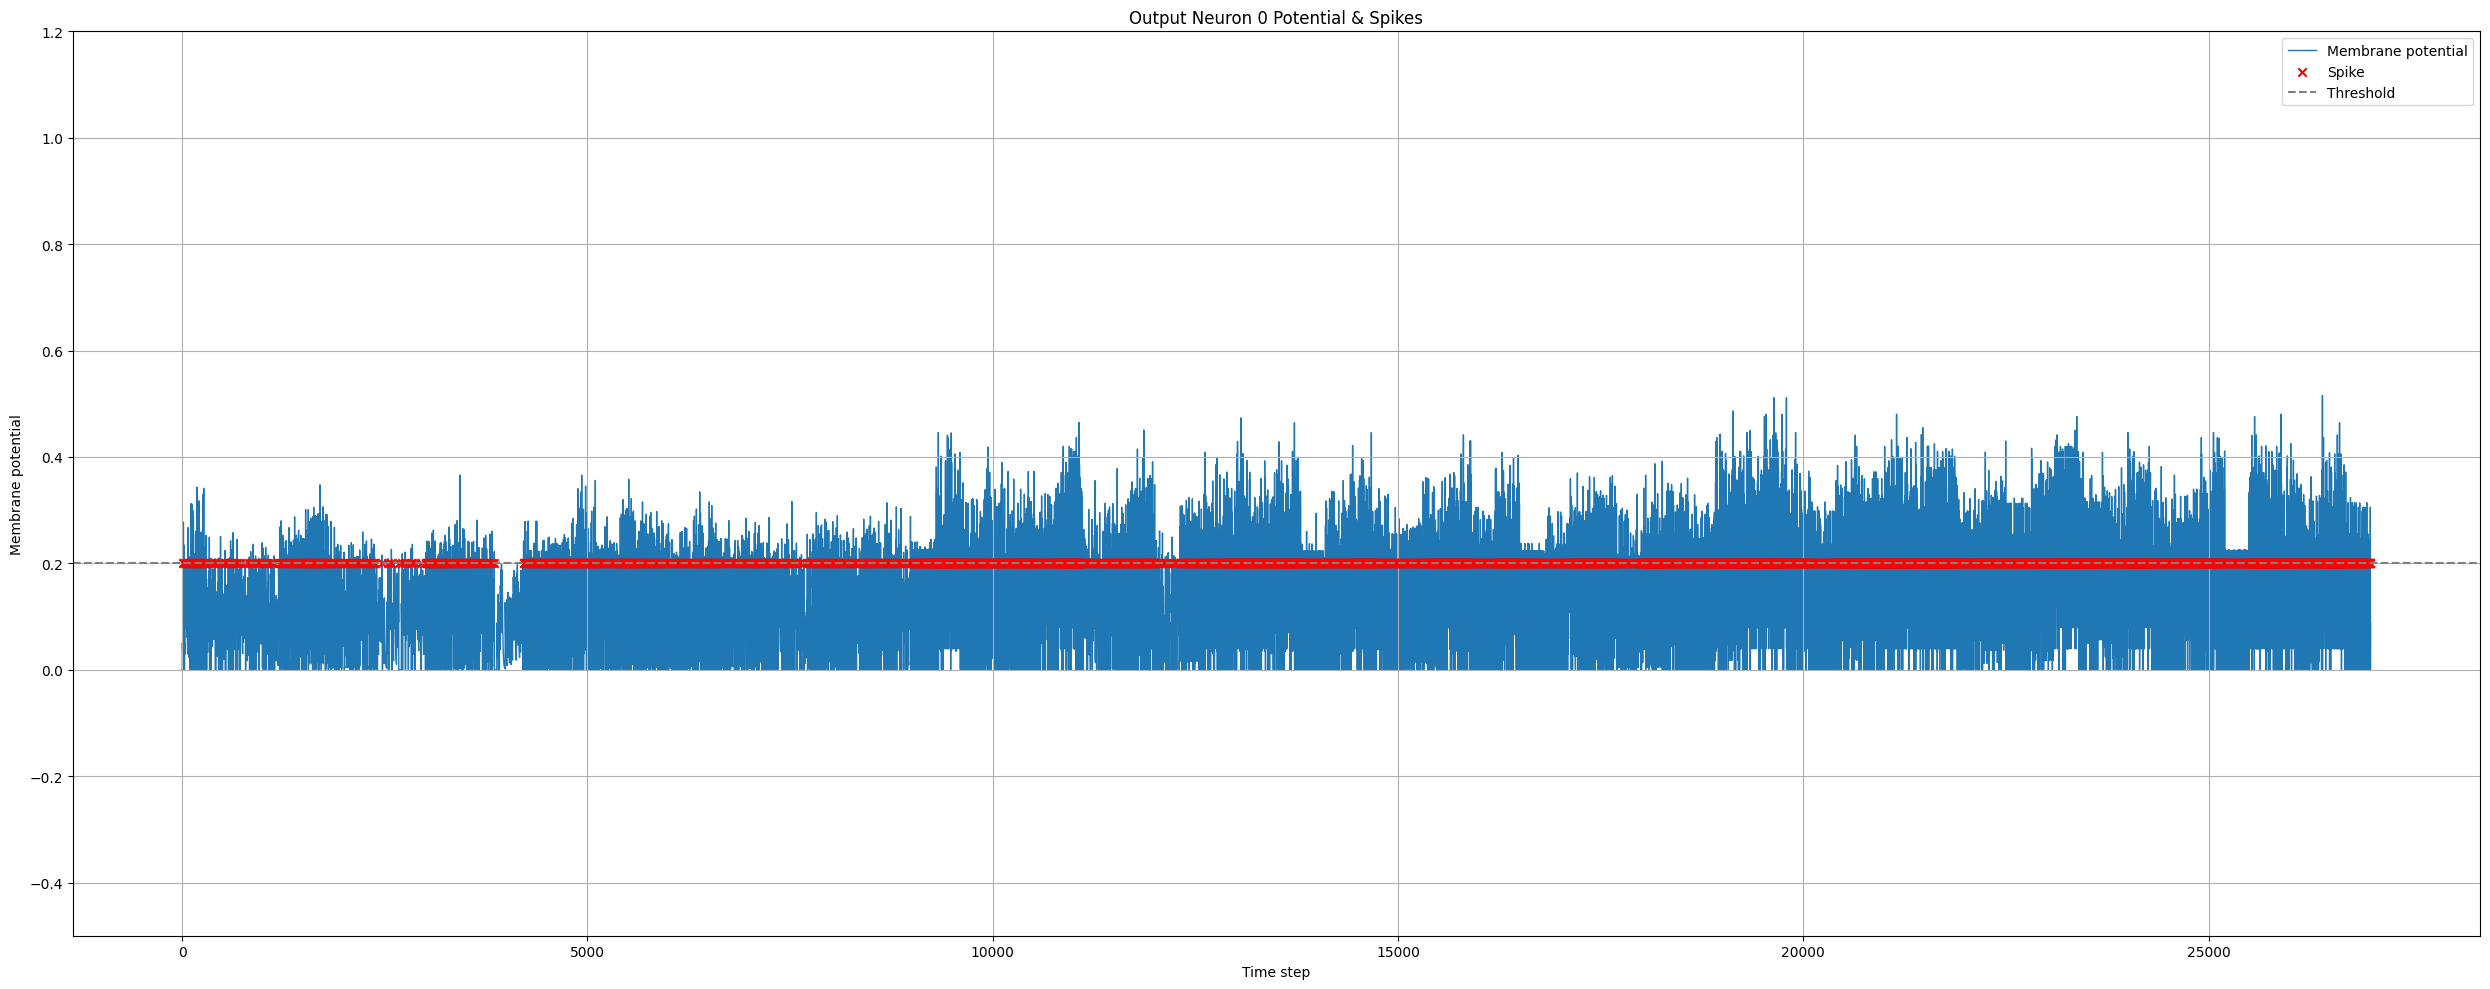

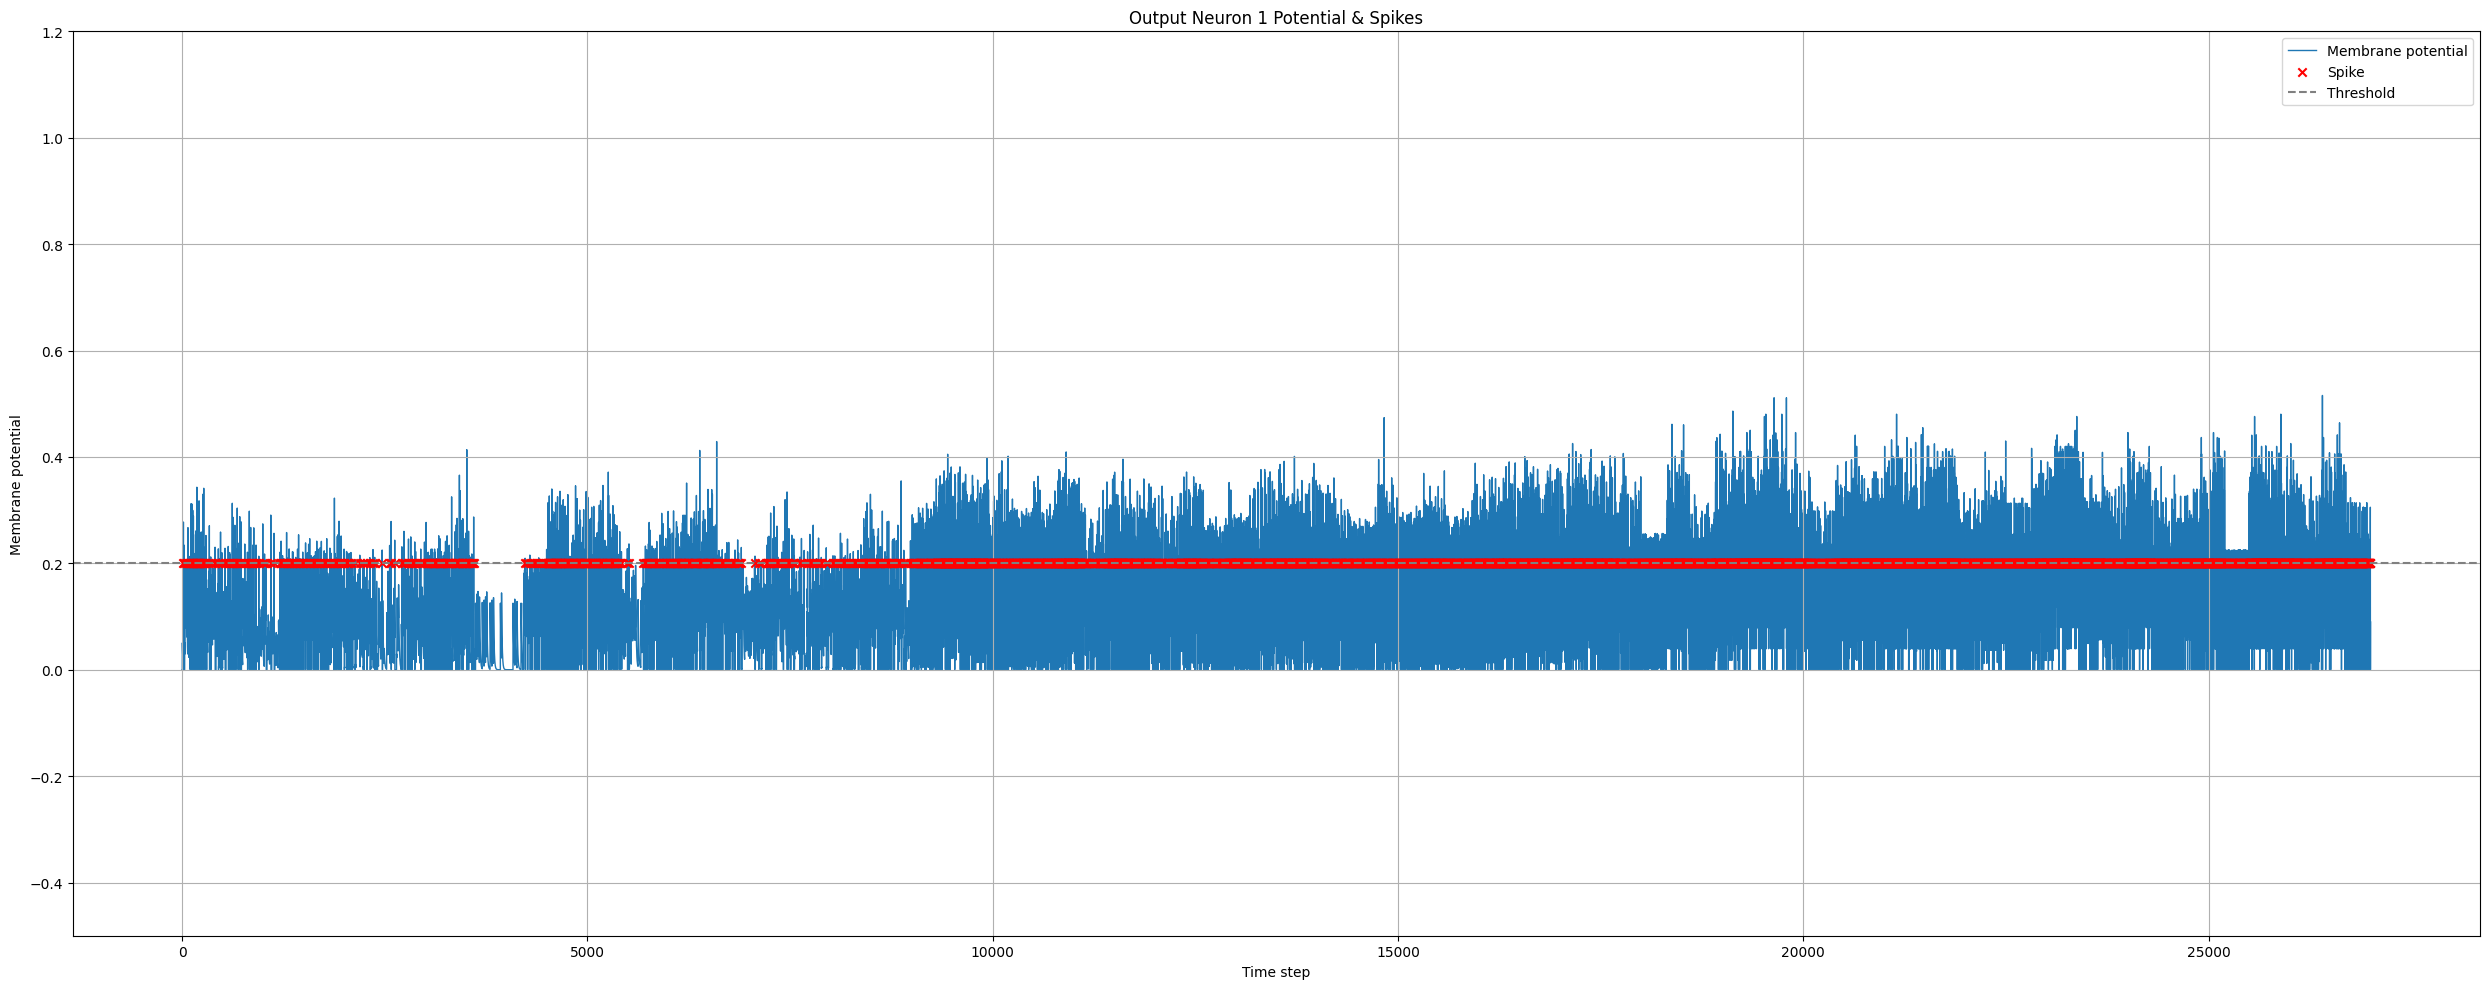

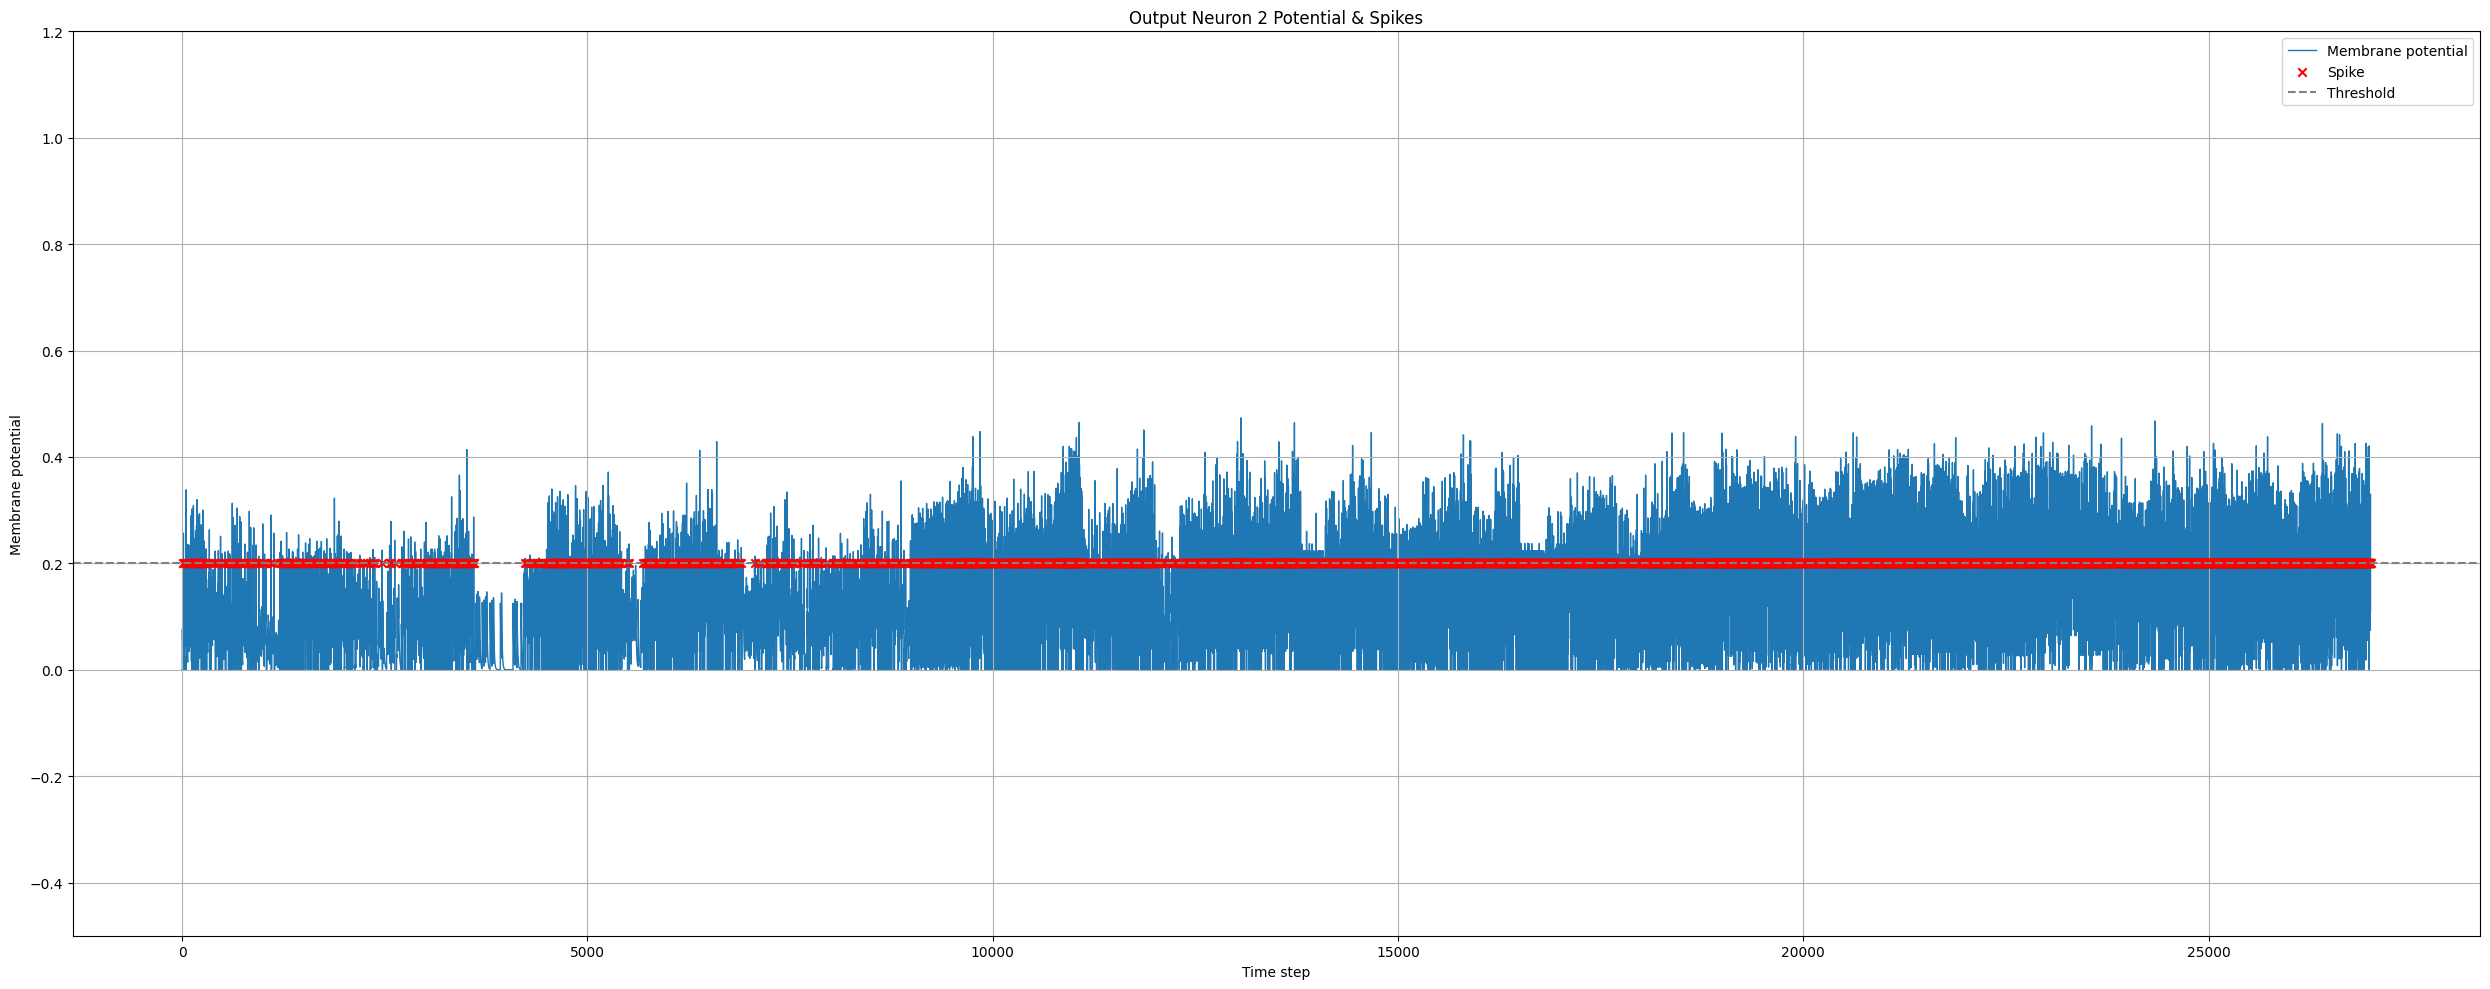

In [ ]:
classifier.train(X_train, y_train, 5)

Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 1, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 1, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: -1, Correct: 0
Predicted: 1, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 0, Correct: 0
Predicted: 1, Correct: 0
Predicted: 0, Correct: 1
Predicted: 1, Correct: 1
Predicted: 1, Correct: 1
Predicted: 0, Correct: 1
Predicted: 1, Correct: 1
Predicted: 1, Correct: 1
Predicted: 1, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 1, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 1, Correct: 1
Predicted: 1, Correct: 1
Predicted: 1, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1
Predicted: 0, Correct: 1

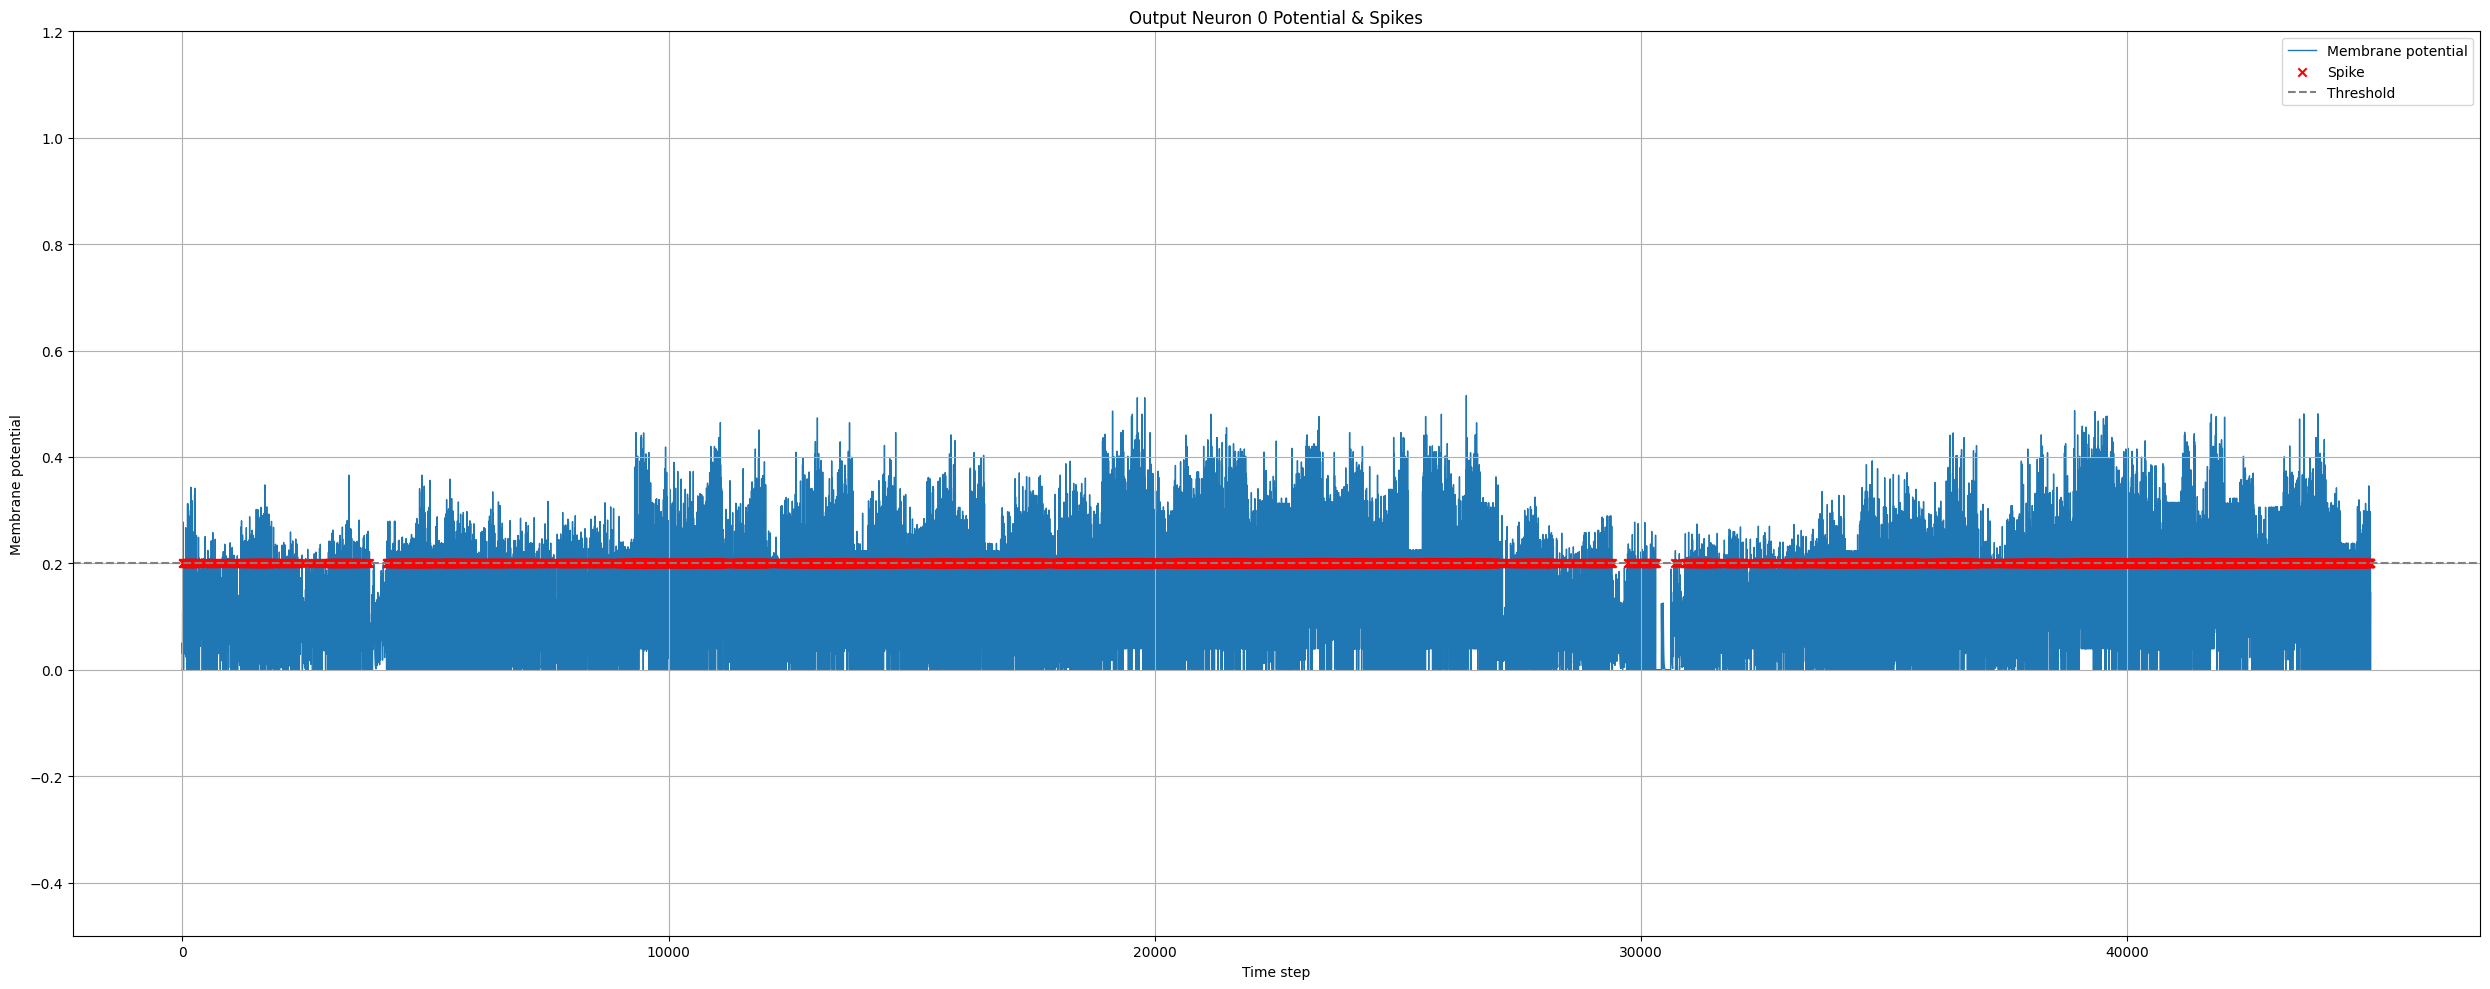

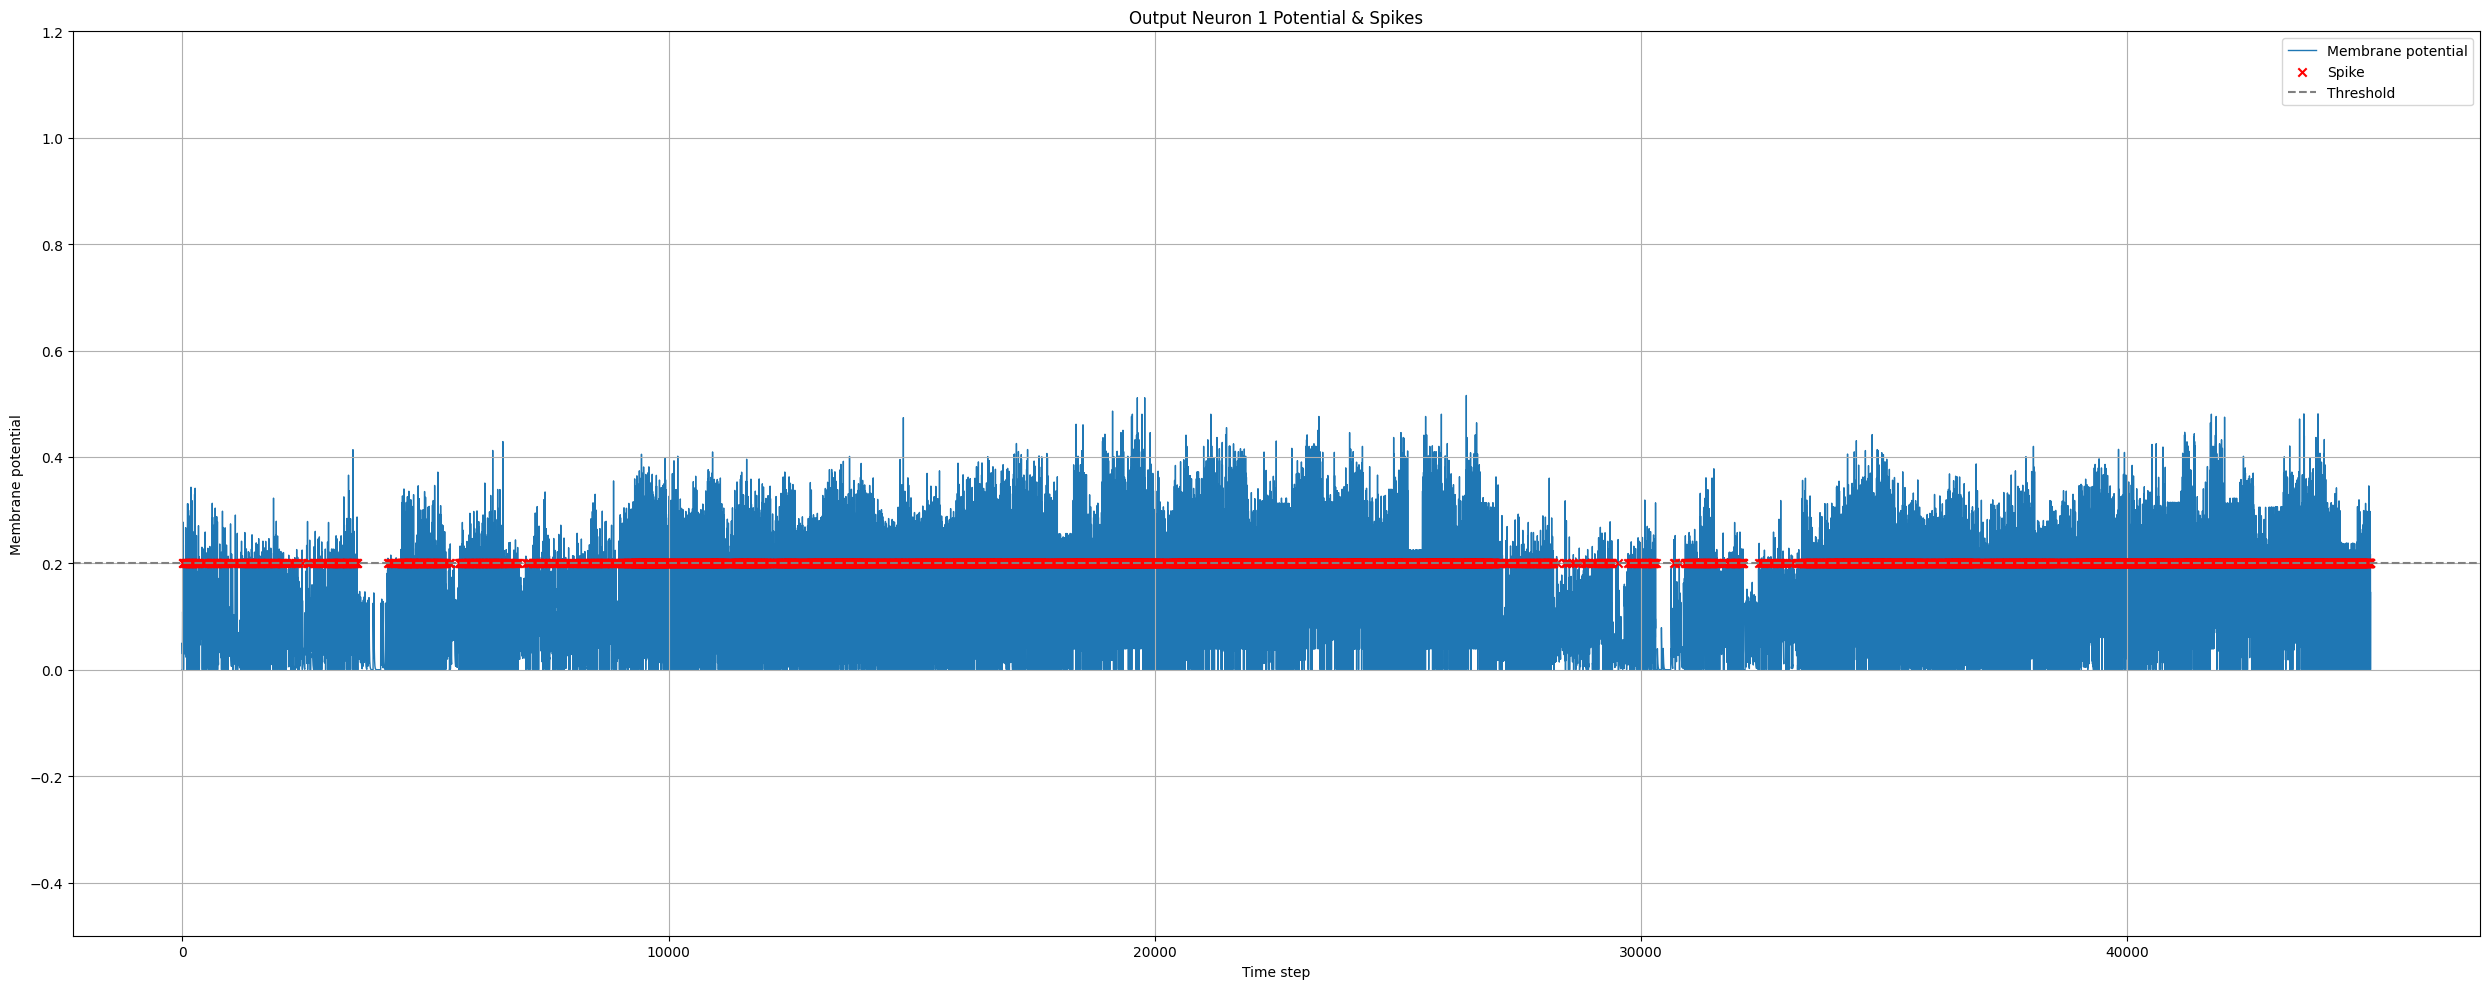

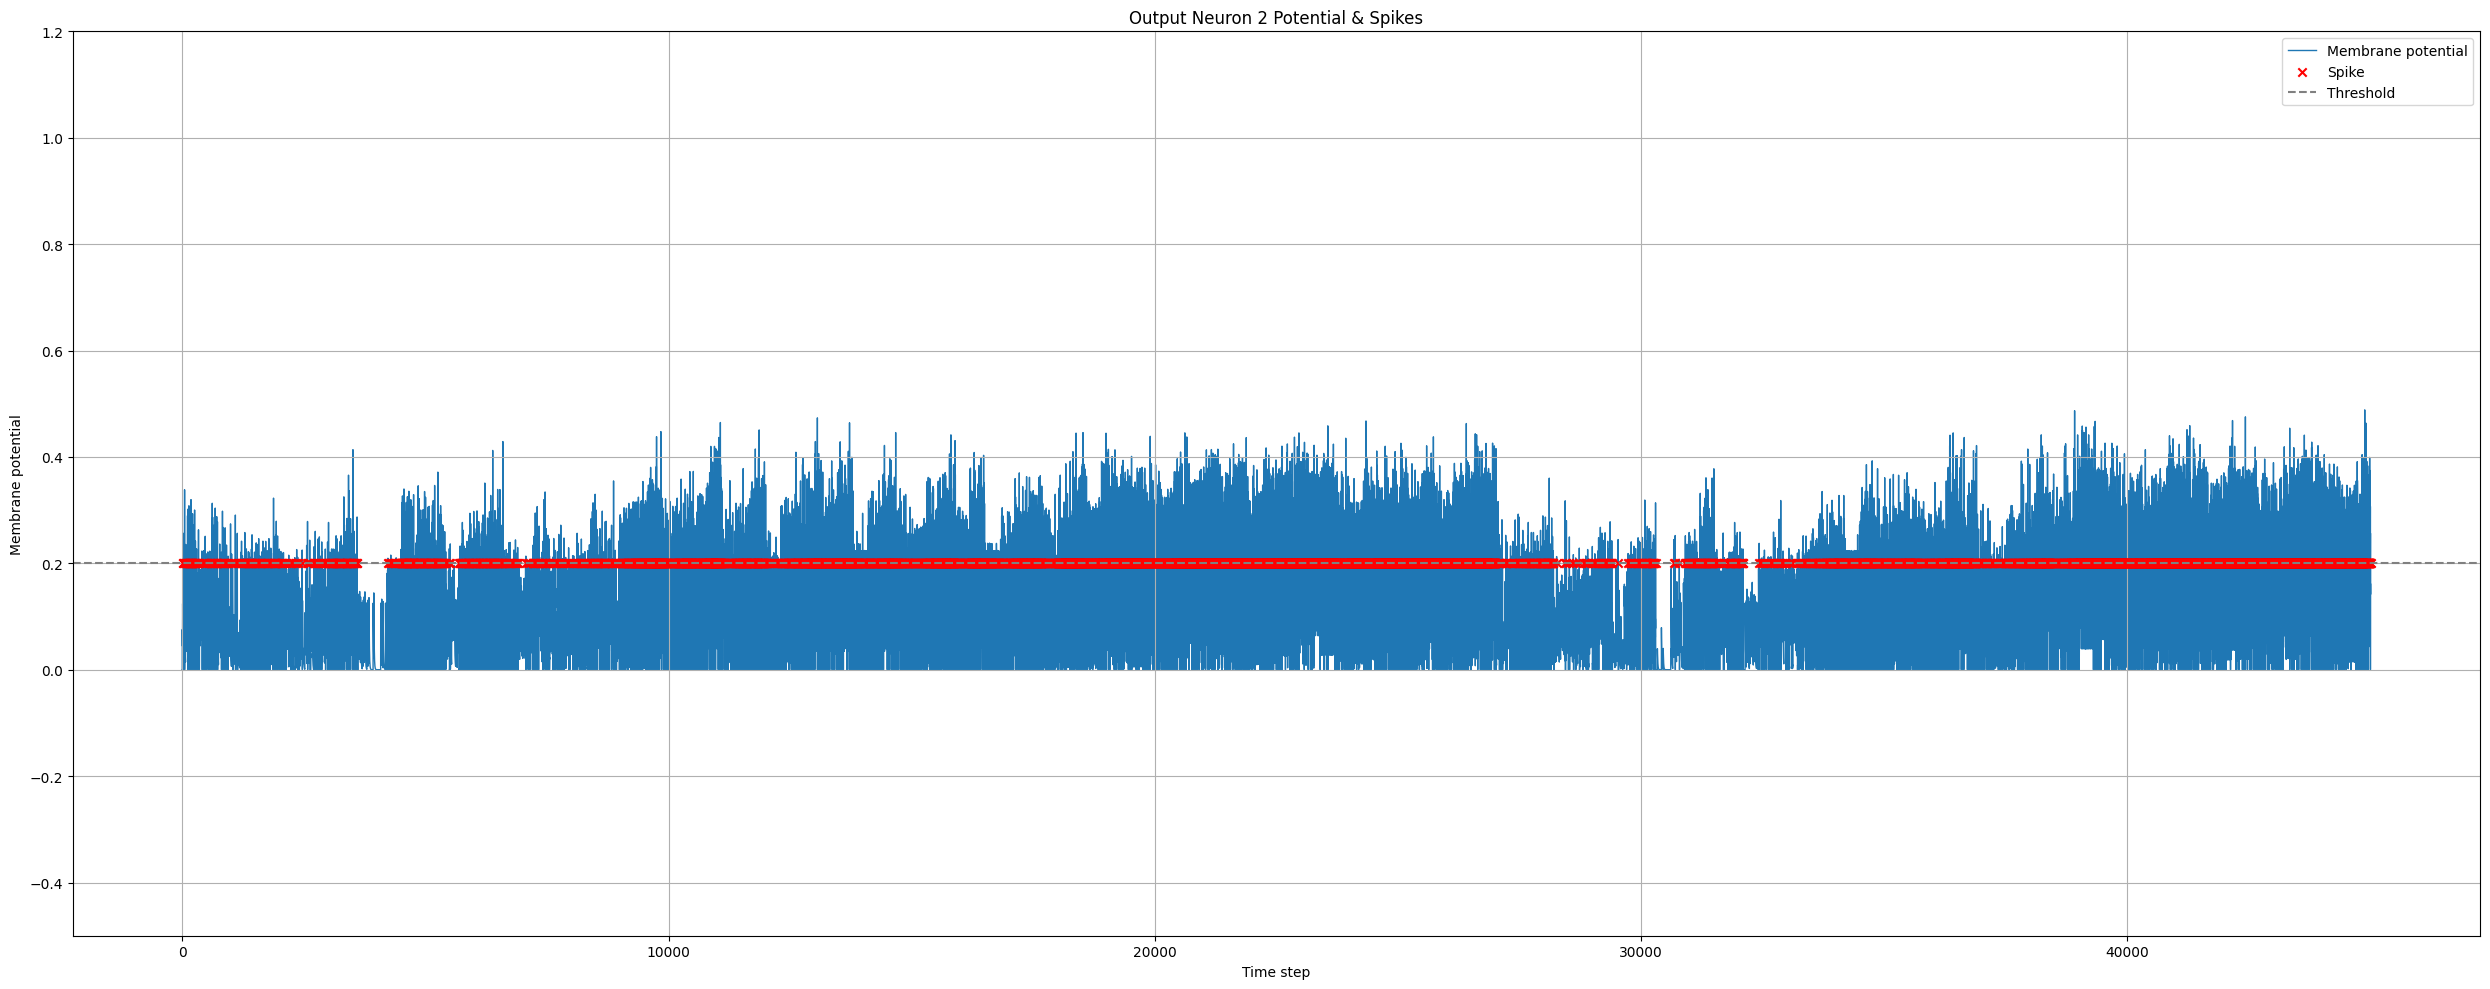

55.00000000000001
8.988415002822876


In [7]:
start = time.time()
print(classifier.test(X_test, y_test, True))
end = time.time()
print(end - start)